# EbayesThresh Torch

SEOYEON CHOI  
2024-07-31

ref

-   [R_ebayesthresh](https://cran.r-project.org/web/packages/EbayesThresh/EbayesThresh.pdf)
-   [교수님
    블로그](https://guebin.github.io/STML2022/posts/II.%20DNN/2022-10-12-6wk.html#%EC%8B%9C%EB%B2%A4%EC%BD%94%EC%A0%95%EB%A6%AC)

# Import

In [3]:
import matplotlib.pyplot as plt
import ebayesthresh_torch
import torch

In [4]:
torch.set_printoptions(precision=15)

## import for code check

In [3]:
from scipy.stats import norm
from scipy.optimize import minimize

# beta.cauchy

> Function beta for the quasi-Cauchy prior

-   Description

> Given a value or vector x of values, find the value(s) of the function
> $\beta(x) = g(x)/\phi(x) − 1$, where $g$ is the convolution of the
> quasi-Cauchy with the normal density $\phi(x)$.

*x가 입력되면 코시 분포와 정규 분포를 혼합해서 함수 베타 구하기*

In [16]:
x = torch.tensor([-2.0,1.0,0.0,-4.0,8.0,50.0],dtype=torch.float64)
x

In [17]:
phix = torch.tensor(norm.pdf(x, loc=0, scale=1))
phix

In [18]:
j = (x != 0)
j

In [19]:
beta = x.clone()
beta

In [20]:
beta = torch.where(j == False, -1/2, beta)
beta

In [21]:
beta[j] = (torch.tensor(norm.pdf(0, loc=0, scale=1)) / phix[j] - 1) / (x[j] ** 2) - 1
beta

In [22]:
beta

-   R code

``` r
beta.cauchy <- function(x) {
#
#   Find the function beta for the mixed normal prior with Cauchy
#   tails.  It is assumed that the noise variance is equal to one.
#
    phix <- dnorm(x)
    j <- (x != 0)
    beta <- x
    beta[!j] <- -1/2
    beta[j] <- (dnorm(0)/phix[j] - 1)/x[j]^2 - 1
    return(beta)
}
```

**결과**

-   Python

In [23]:
ebayesthresh_torch.beta_cauchy(torch.tensor([-2,1,0,-4,8,50]))

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float64)

-   R

``` r
> beta.cauchy(c(-2,1,0,-4,8,50))
[1]  5.972640e-01 -3.512787e-01 -5.000000e-01  1.852474e+02  1.233796e+12           Inf
```

# beta.laplace

> Function beta for the Laplace prior

-   Description

> Given a single value or a vector of $x$ and $s$, find the value(s) of
> the function $\beta(x; s, a) = \frac{g(x; s, a)}{f_n(x; 0, s)}−1$,
> where $f_n(x; 0, s)$ is the normal density with mean $0$ and standard
> deviation $s$, and $g$ is the convolution of the Laplace density with
> scale parameter a, $γa(\mu)$, with the normal density $f_n(x; µ, s)$
> with mean mu and standard deviation $s$.

*평균이 $\mu$이며, 스케일 파라메터 a를 가진 라플라스와 정규분포의
합성함수 $g$와 평균이 0이고 표준편차가s인 f로 계산되는 함수 베타*

In [24]:
x = torch.tensor([-2,1,0,-4,8,50])
# x = torch.tensor([2.14])
# s = 1
s = torch.arange(1, 7)
a = 0.5

-   s는 표준편차
-   a는 Laplaxe prior모수, 이 값이 클수록 부포 모양이 뾰족해진다.

In [25]:
x = torch.abs(x)

In [26]:
xpa = x / s + s * a
xpa

In [27]:
xma = x / s - s * a
xma

In [28]:
rat1 = torch.tensor(1 / xpa, dtype=torch.float64)
rat1

  rat1 = torch.tensor(1 / xpa, dtype=torch.float64)

In [29]:
rat1[xpa < 35] = torch.tensor(norm.cdf(-xpa[xpa < 35], loc=0, scale=1) / norm.pdf(xpa[xpa < 35], loc=0, scale=1))
rat1

In [30]:
rat2 = torch.tensor(1 / torch.abs(xma), dtype=torch.float64)
rat2

  rat2 = torch.tensor(1 / torch.abs(xma), dtype=torch.float64)

In [31]:
xma = torch.where(xma > 35, torch.tensor(35.0), xma)
xma

In [32]:
rat2[xma > -35] = torch.tensor(norm.cdf(xma[xma > -35], loc=0, scale=1) / norm.pdf(xma[xma > -35], loc=0, scale=1))
rat2

In [33]:
beta = (a * s) / 2 * (rat1 + rat2) - 1
beta

-   R code

``` r
beta.laplace <- function(x, s = 1, a = 0.5) {
#
#  The function beta for the Laplace prior given parameter a and s (sd)
#
    x <- abs(x)
    xpa <- x/s + s*a
    xma <- x/s - s*a
    rat1 <- 1/xpa
    rat1[xpa < 35] <- pnorm( - xpa[xpa < 35])/dnorm(xpa[xpa < 35])
    rat2 <- 1/abs(xma)
    xma[xma > 35] <- 35
    rat2[xma > -35] <- pnorm(xma[xma > -35])/dnorm(xma[xma > -35])
    beta <- (a * s) / 2 * (rat1 + rat2) - 1
    return(beta)
}
```

**결과**

-   Python

In [34]:
ebayesthresh_torch.beta_laplace(torch.tensor([-2,1,0,-4,8,50]),s=1)

In [35]:
ebayesthresh_torch.beta_laplace(torch.tensor([-2.0]),s=1,a=0.5)

In [36]:
ebayesthresh_torch.beta_laplace(torch.tensor([-2,1,0,-4,8,50]),s=torch.arange(1, 7),a = 1)

-   R

``` r
> beta.laplace(c(-2,1,0,-4,8,50), s=1)
[1]   8.898520e-01  -3.800417e-01  -5.618178e-01   2.854595e+02   1.026981e+12  6.344540e+265
> beta.laplace(-2, s=1, a=0.5)
[1] 0.889852
> beta.laplace(c(-2,1,0,-4,8,50), s=1:6, a=1)
[1]   0.890821055  -0.129919250  -0.086229104  -0.005203193   0.054213718 112.493576777
```

# cauchy_medzero

> the objective function that has to be zeroed, component by component,
> to find the posterior median when the quasi-Cauchy prior is used. x is
> the parameter vector, z is the data vector, w is the weight x and z
> may be scalars

-   quasi-Cauchy prior에서 사후 중앙값 찾기 위한 함수
-   x,z는 벡터일수도 있고, 스칼라일 수 도 있다.

In [37]:
x =  torch.tensor([-2,1,0,-4,8,50])
# x = torch.tensor(4)
z =  torch.tensor([1,0,2,3,-1,-1])
# z = torch.tensor(5)
w = torch.tensor(0.5)

In [38]:
hh = z - x
hh

In [39]:
dnhh = torch.tensor(norm.pdf(hh, loc=0, scale=1))
dnhh

In [40]:
norm.cdf(hh, loc=0, scale=1)

In [41]:
yleft = torch.tensor(norm.cdf(hh, loc=0, scale=1)) - z * dnhh + ((z * x - 1) * dnhh * torch.tensor(norm.cdf(-x, loc=0, scale=1) )) / torch.tensor(norm.pdf(x, loc=0, scale=1))
yleft

In [42]:
yright2 = 1 + torch.exp(-z**2 / 2) * (z**2 * (1/w - 1) - 1)
yright2

In [43]:
yright2 / 2 - yleft

-   R코드

``` r
cauchy.medzero <- function(x, z, w) {
#    
# the objective function that has to be zeroed, component by
# component, to find the posterior median when the quasi-Cauchy prior
# is used.  x is the parameter vector, z is the data vector, w is the
# weight x and z may be scalars
#
    hh <- z - x
    dnhh <- dnorm(hh)
    yleft <- pnorm(hh) - z * dnhh + ((z * x - 1) * dnhh * pnorm( - x))/
        dnorm(x)
    yright2 <- 1 + exp( - z^2/2) * (z^2 * (1/w - 1) - 1)
    return(yright2/2 - yleft)
}
```

**결과**

-   Python
    -   벡터, 스칼라일때 가능한지 확인

In [44]:
ebayesthresh_torch.cauchy_medzero(torch.tensor([-2,1,0,-4,8,50]),torch.tensor([1,0,2,3,-1,-1]),0.5)

In [45]:
ebayesthresh_torch.cauchy_medzero(torch.tensor(4),torch.tensor(5),torch.tensor(0.5))

-   R

``` r
> cauchy.medzero(c(-2,1,0,-4,8,50),c(1,0,2,3,-1,-1),0.5)
[1] -0.25356559  0.00000000 -0.09859737 -0.45556313  0.50000000         NaN
> cauchy.medzero(4,5,0.5)
[1] -0.2194424
```

# cauchy_threshzero

-   cauchy 임계값 찾기 위한 것
-   아래에서 반환되는 y가 0에 가깝도록 만들어주는 z를 찾는 과정

In [46]:
z = torch.tensor([1,0,2,3,-1,-1])
# z = 0
# w = 0.5
w = torch.tensor([0.5,0.4,0.3,0.2,0,0.1])

In [47]:
y = (torch.tensor(norm.cdf(z, loc=0, scale=1)) - z * torch.tensor(norm.pdf(z, loc=0, scale=1)) - 0.5 - (z**2 * torch.exp(-z**2 / 2) * (1/w - 1)) / 2)
y

-   R 코드

``` r
cauchy.threshzero <- function(z, w) {
#    
# The objective function that has to be zeroed to find the Cauchy
# threshold. z is the putative threshold vector, w is the weight w
# can be a vector
#
    y <- pnorm(z) - z * dnorm(z) - 1/2 -
         (z^2 * exp( - z^2/2) * (1/w - 1))/2
    return(y)
}
```

**결과**

-   Python

In [48]:
ebayesthresh_torch.cauchy_threshzero(torch.tensor([1,0,2,3,-1,-1]),0.5)

In [49]:
ebayesthresh_torch.cauchy_threshzero(torch.tensor([1,0,2,3,-1,-1]),torch.tensor([0.5,0.4,0.3,0.2,0,0.1]))

-   R

``` r
> cauchy.threshzero(c(1,0,2,3,-1,-1),0.5)
[1] -0.20389131  0.00000000  0.09859737  0.43536407 -0.40263935 -0.40263935
cauchy.threshzero(c(1,0,2,3,-1,-1), c(0.5,0.4,0.3,0.2,0,0.1))
[1] -0.2038913  0.0000000 -0.2622967  0.2853926       -Inf -2.8287620
```

# ebayesthresh

In [3]:
x = torch.normal(torch.tensor([0] * 90 + [5] * 10, dtype=torch.float32), torch.ones(100, dtype=torch.float32))
# sdev = None
sdev = 1
prior="laplace"
a=0.5
bayesfac=False
verbose=False
threshrule="median"
universalthresh=True
stabadjustment=None

In [4]:
pr = prior[0:1]
pr

In [5]:
if sdev is None: sdev = torch.tensor([float('nan')])
else: sdev = torch.tensor([sdev])

In [6]:
if len(sdev) == 1:
    if stabadjustment is not None:
        raise ValueError("Argument stabadjustment is not applicable when variances are homogeneous.")
    if torch.isnan(sdev):
        sdev = ebayesthresh_torch.mad(x, center=0)
    stabadjustment_condition = True
else:
    if pr == "c":
        raise ValueError("Standard deviation has to be homogeneous for Cauchy prior.")
    if sdev.numel() != x.numel():
        raise ValueError("Standard deviation has to be homogeneous or have the same length as observations.")
    if stabadjustment is None:
        stabadjustment = False
    stabadjustment_condition = stabadjustment

In [7]:
if stabadjustment_condition:
    sdev = sdev.float()
    m_sdev = torch.mean(sdev) 
    s = sdev / m_sdev
    x = x / m_sdev
else:
    s = sdev

In [8]:
if pr == "l" and a is None:
    pp = ebayesthresh_torch.wandafromx(x, s, universalthresh)
    w = pp["w"]
    a = pp["a"]
else:
    w = ebayesthresh_torch.wfromx(x, s, prior, a, universalthresh)

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:584: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(s, dtype=torch.float)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tma = torch.tensor(tt / s - s * a)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:47: UserWa

In [9]:
if pr != "m" or verbose:
    tt = ebayesthresh_torch.tfromw(w, s, prior=prior, bayesfac=bayesfac, a=a)[0]
    if stabadjustment_condition:
        tcor = tt * m_sdev
    else:
        tcor = tt

In [10]:
if threshrule == "median":
    muhat = ebayesthresh_torch.postmed(x, s, w, prior=prior, a=a)
elif threshrule == "mean":
    muhat = ebayesthresh_torch.postmean(x, s, w, prior=prior, a=a)
elif threshrule == "hard":
    muhat = ebayesthresh_torch.threshld(x, tt)
elif threshrule == "soft":
    muhat = ebayesthresh_torch.threshld(x, tt, hard=False)
elif threshrule == "none":
    muhat = None
else:
    raise ValueError(f"Unknown threshold rule: {threshrule}")

In [11]:
muhat

In [12]:
if stabadjustment_condition:
    muhat = muhat * m_sdev

In [13]:
muhat

In [14]:
if not verbose:
    muhat
else:
    retlist = {
        'muhat': muhat,
        'x': x,
        'threshold.sdevscale': tt,
        'threshold.origscale': tcor,
        'prior': prior,
        'w': w,
        'a': a,
        'bayesfac': bayesfac,
        'sdev': sdev,
        'threshrule': threshrule
    }
    if pr == "c":
        del retlist['a']
    if threshrule == "none":
        del retlist['muhat']
    retlist

R코드

``` r
ebayesthresh <- function (x, prior = "laplace", a = 0.5, bayesfac = FALSE,
                          sdev = NA, verbose = FALSE, threshrule = "median",
                          universalthresh = TRUE, stabadjustment) {
#  
#  Given a vector of data x, find the marginal maximum likelihood
#  estimator of the mixing weight w, and apply an appropriate
#  thresholding rule using this weight.
#
#  If the prior is laplace and a=NA, then the inverse scale parameter
#  is also found by MML.
#
#  Standard deviation sdev can be a vector (heterogeneous variance) or
#  a single value (homogeneous variance). If sdev=NA, then it is
#  estimated using the function mad(x). Heterogeneous variance is
#  allowed only for laplace prior currently.
#    
#  The thresholding rules allowed are "median", "mean", "hard", "soft"
#  and "none"; if "none" is used, then only the parameters are worked
#  out.
#
#  If hard or soft thresholding is used, the argument "bayesfac"
#  specifies whether to use the bayes factor threshold or the
#  posterior median threshold.
#    
#  If universalthresh=TRUE, the thresholds will be upper bounded by
#  universal threshold adjusted by standard deviation; otherwise,
#  weight w will be searched in [0, 1].
#    
#  If stabadjustment=TRUE, the observations and standard deviations
#  will be first divided by the mean of all given standard deviations
#  in case of inefficiency due to large value of standard
#  deviation. In the case of homogeneous variance, the standard
#  deviations will be normalized to 1 automatically.
#
#  If verbose=TRUE then the routine returns a list with several
#  arguments, including muhat which is the result of the
#  thresholding. If verbose=FALSE then only muhat is returned.
#
    
  # Find the standard deviation if necessary and estimate the parameters
  pr <- substring(prior, 1, 1)

  if(length(sdev) == 1) {
      if(!missing(stabadjustment))
        stop(paste("Argument stabadjustment is not applicable when",
                   "variances are homogeneous."))
      if(is.na(sdev)) {
          sdev <- mad(x, center = 0)
      }
      stabadjustment_condition = TRUE
  } else{
    if(pr == "c")
      stop("Standard deviation has to be homogeneous for Cauchy prior.")
    if(length(sdev) != length(x))
      stop(paste("Standard deviation has to be homogeneous or has the",
                 "same length as observations."))
    if(missing(stabadjustment))
      stabadjustment <- FALSE
    stabadjustment_condition = stabadjustment
  }
  
  if (stabadjustment_condition) {
    m_sdev <- mean(sdev)
    s <- sdev/m_sdev
    x <- x/m_sdev
  } else { s <- sdev }
  
    if ((pr == "l") & is.na(a)) {
      pp <- wandafromx(x, s, universalthresh)
          w  <- pp$w
          a  <- pp$a
    }
    else
          w <- wfromx(x, s, prior = prior, a = a, universalthresh)
    if(pr != "m" | verbose) {
      tt <- tfromw(w, s, prior = prior, bayesfac = bayesfac, a = a)
      if(stabadjustment_condition) {
        tcor <- tt * m_sdev
          } else {
            tcor <- tt
          }
    }
    if(threshrule == "median")
        muhat <- postmed(x, s, w, prior = prior, a = a)
    if(threshrule == "mean")
    muhat <- postmean(x, s, w, prior = prior, a = a)
    if(threshrule == "hard")
        muhat <- threshld(x, tt)
    if(threshrule == "soft")
        muhat <- threshld(x, tt, hard = FALSE)
        if(threshrule == "none")
                muhat <- NA

    # Now return desired output
    if(stabadjustment_condition) {
      muhat <- muhat * m_sdev
    }
    if(!verbose)
            return(muhat)
    retlist <- list(muhat = muhat, x = x, threshold.sdevscale = tt, 
                        threshold.origscale = tcor, prior = prior, w = w,
                        a = a, bayesfac = bayesfac, sdev = sdev,
                        threshrule = threshrule)
    if(pr == "c")
        retlist <- retlist[-7]
    if(threshrule == "none")
        retlist <- retlist[-1]
    return(retlist)
}
```

결과

-   Python

In [15]:
ebayesthresh_torch.ebayesthresh(x=torch.normal(torch.tensor([0] * 90 + [5] * 10, dtype=torch.float32), torch.ones(100, dtype=torch.float32)), sdev = 1)

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.isnan(torch.tensor(sdev)):

-   R

``` r
> ebayesthresh(x = rnorm(100, c(rep(0,90), rep(5,10))),
+              prior = "laplace", sdev = 1)
  [1]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [15]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [29]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [43]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [57]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000
 [71]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 -0.4480064
 [85]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  5.1534865  6.2732386  4.4612851  5.9931848  4.5828731  4.6154038  4.8247775  3.6219544
 [99]  4.4480080  5.4084453
```

# isotone

> Isotonic Regression은 입력 변수에 따른 출력 변수의 단조 증가(monotonic
> increasing) 또는 감소(monotonic decreasing) 패턴을 찾는 방법

In [50]:
beta = ebayesthresh_torch.beta_cauchy(torch.tensor([-2,1,0,-4]))
w = torch.ones(len(beta))
aa = w + 1/beta
x = w + aa
wt = 1/aa**2
increasing = False

In [51]:
if wt is None:
        wt = torch.ones_like(x)

In [52]:
nn = len(x)
nn

In [53]:
ebayesthresh_torch.beta_cauchy(torch.tensor([-2,1,0,-4]))

In [54]:
if nn == 1:
    x = x

if not increasing:
    x = -x

In [55]:
ip = torch.arange(nn)
ip

In [56]:
dx = torch.diff(x)
dx

In [57]:
nx = len(x)
nx

In [58]:
while (nx > 1) and (torch.min(dx) < 0):
        jmax = torch.where((torch.cat([dx <= 0, torch.tensor([False])]) & torch.cat([torch.tensor([True]), dx > 0])))[0]
        jmin = torch.where((torch.cat([dx > 0, torch.tensor([True])]) & torch.cat([torch.tensor([False]), dx <= 0])))[0]
        

        for jb in range(len(jmax)):
            ind = torch.arange(jmax[jb], jmin[jb] + 1)
            wtn = torch.sum(wt[ind])
            x[jmax[jb]] = torch.sum(wt[ind] * x[ind]) / wtn
            wt[jmax[jb]] = wtn
            x[jmax[jb] + 1:jmin[jb] + 1] = torch.nan

        ind = ~torch.isnan(x)
        x = x[ind]
        wt = wt[ind]
        ip = ip[ind]
        dx = torch.diff(x)
        nx = len(x)

In [59]:
jj = torch.zeros(nn, dtype=torch.int32)
jj

In [60]:
jj[ip] = 1
jj

In [61]:
z = x[torch.cumsum(jj, dim=0) - 1]
z

In [62]:
if not increasing:
        z = -z

In [63]:
z

R코드

``` r
isotone <- function(x, wt = rep(1, length(x)), increasing = FALSE) {
#
#   find the weighted least squares isotone fit to the 
#   sequence x, the weights given by the sequence wt
#
#   if increasing == TRUE the curve is set to be increasing, 
#   otherwise to be decreasing
#
#   the vector ip contains the indices on the original scale of the
#   breaks in the regression at each stage
#
    nn <- length(x)
    if(nn == 1)
        return(x)
    if(!increasing)
        x <-  - x
    ip <- (1:nn)
    dx <- diff(x)
    nx <- length(x)
    while((nx > 1) && (min(dx) < 0)) {
#
#  do single pool-adjacent-violators step
#
#  find all local minima and maxima
#
        jmax <- (1:nx)[c(dx <= 0, FALSE) & c(TRUE, dx > 0)]
        jmin <- (1:nx)[c(dx > 0, TRUE) & c(FALSE, dx <= 0)]
#  do pav step for each pair of maxima and minima
#
#  add up weights within subsequence that is pooled
#  set first element of subsequence to the weighted average
#  the first weight to the sum of the weights within the subsequence
#    and remainder of the subsequence to NA
#
        for(jb in (1:length(jmax))) {
            ind <- (jmax[jb]:jmin[jb])
            wtn <- sum(wt[ind])
            x[jmax[jb]] <- sum(wt[ind] * x[ind])/wtn
            wt[jmax[jb]] <- wtn
            x[(jmax[jb] + 1):jmin[jb]] <- NA
        }
#
#  clean up within iteration, eliminating the parts of sequences that
#  were set to NA
#
        ind <- !is.na(x)
        x <- x[ind]
        wt <- wt[ind]
        ip <- ip[ind]
        dx <- diff(x)
        nx <- length(x)
    }
# 
#  final cleanup: reconstruct z at all points by repeating the pooled
#    values the appropriate number of times
#
    jj <- rep(0, nn)
    jj[ip] <- 1
    z <- x[cumsum(jj)]
    if(!increasing)
        z <-  - z
    return(z)
}
```

결과

-   Python

In [64]:
beta = ebayesthresh_torch.beta_cauchy(torch.tensor([-2,1,0,-4]))
w = torch.ones(len(beta))
aa = w + 1/beta
ps = w + aa
ww = 1/aa**2
wnew = ebayesthresh_torch.isotone(ps, ww, increasing = False)
wnew

R

``` r
> beta <- beta.cauchy(c(-2,1,0,-4))
> w <- rep(1, length(x))
> aa = w + 1/beta
> ps = w + aa
> ww = 1/aa**2
> wnew = isotone(ps, ww, increasing = FALSE)
> wnew
[1] 3.674301 0.760411 0.760411 0.760411
```

# laplace_threshzero

In [65]:
x = torch.tensor([-2,1,0,-4,8,50])
s = 1
w = 0.5
a = 0.5

In [66]:
a = min(a, 20)
a

In [67]:
xma = x / s - s * a
xma

In [68]:
z = torch.tensor(norm.cdf(xma, loc=0, scale=1)) - (1 / a) * (1 / s * torch.tensor(norm.pdf(xma, loc=0, scale=1))) * (1 / w + ebayesthresh_torch.beta_laplace(x, s, a))
z

R코드

``` r
laplace.threshzero <- function(x, s = 1, w = 0.5, a = 0.5) {
#
# The function that has to be zeroed to find the threshold with the
# Laplace prior.  Only allow a < 20 for input value.
#    
  a <- min(a, 20)
  xma <- x/s - s*a
  z <- pnorm(xma) - 1/a * (1/s*dnorm(xma)) * (1/w + beta.laplace(x, s, a))
  return(z)
}
```

결과

-   Python

In [69]:
ebayesthresh_torch.laplace_threshzero(torch.tensor([-2,1,0,-4,8,50]), s = 1, w = 0.5, a = 0.5)

In [70]:
ebayesthresh_torch.laplace_threshzero(torch.tensor(-5), s = 1, w = 0.5, a = 0.5)

-   R

``` r
> laplace.threshzero(c(-2,1,0,-4,8,50), s = 1, w = 0.5, a = 0.5)
[1] -0.095098724 -0.449199824 -0.704130654 -0.009185958  0.500000000  1.000000000
> laplace.threshzero(-5, s = 1, w = 0.5, a = 0.5)
[1] -0.003369168
```

# negloglik_laplace

> Marginal negative log likelihood function for laplace prior.

-   라플라스 프라이어에 대한 한계음의로그우도함수 계산

In [71]:
xpar = torch.tensor([0.5,0.6,0.3])
xx = torch.tensor([1,2,3,4,5])
ss = torch.tensor([1])
tlo = torch.sqrt(2 * torch.log(torch.tensor(len([1, 2, 3, 4, 5])).float())) * 1
thi = torch.tensor([0.0,0.0,0.0])

In [72]:
a = xpar[1]
a

In [73]:
wlo = ebayesthresh_torch.wfromt(thi, ss, a=a)
wlo

In [74]:
whi = ebayesthresh_torch.wfromt(tlo, ss, a=a)
whi

In [75]:
wlo = torch.max(wlo)
wlo

In [76]:
whi = torch.min(whi)
whi

In [77]:
loglik = torch.sum(torch.log(1 + (xpar[0] * (whi - wlo) + wlo) *
                           ebayesthresh_torch.beta_laplace(xx, ss, a)))
-loglik

R코드

``` r
negloglik.laplace <- function(xpar, xx, ss, tlo, thi) {
#
#  Marginal negative log likelihood function for laplace prior. 
#   Constraints for thresholds need to be passed externally.
#  
#  xx   :data
#  xpar :vector of two parameters:
#      xpar[1] : a value between [0, 1] which will be adjusted to range of w 
#      xpar[2] : inverse scale (rate) parameter ("a")
#  ss   :vector of standard deviations
#  tlo  :lower bound of thresholds
#  thi  :upper bound of thresholds
#
    a <- xpar[2]
        
        # Calculate the range of w given a, using negative monotonicity
        # between w and t
    wlo <- wfromt(thi, ss, a = a)
    whi <- wfromt(tlo, ss, a = a)
    wlo <- max(wlo)
    whi <- min(whi)
    loglik <- sum(log(1 + (xpar[1] * (whi - wlo) + wlo) *
                          beta.laplace(xx, ss, a)))
    return(-loglik)
}
```

결과

-   Python

In [78]:
xpar = torch.tensor([0.5,0.6,0.3])
xx = torch.tensor([1,2,3,4,5])
ss = torch.tensor([1])
tlo = torch.sqrt(2 * torch.log(torch.tensor(len([1, 2, 3, 4, 5])).float())) * 1
thi = torch.tensor([0.0,0.0,0.0])

In [79]:
ebayesthresh_torch.negloglik_laplace(xpar, xx, ss, tlo, thi)

-   R

``` r
> xpar <- c(0.5, 0.6, 0.3)
> xx <- c(1, 2, 3, 4, 5)
> ss <- c(1)
> tlo <- sqrt(2 * log(length(c(1, 2, 3, 4, 5)))) * 1
> thi <- c(0, 0, 0)
> negloglik.laplace(xpar, xx, ss, tlo, thi)
[1] -16.79727
```

# postmean

> Given a single value or a vector of data and sampling standard
> deviations (sd equals 1 for Cauchy prior), find the corresponding
> posterior mean estimate(s) of the underlying signal value(s).

-   적절한 사후 평균 찾기

In [6]:
x = torch.tensor([-2.0,1.0,0.0,-4.0,8.0,50.0])
s = torch.tensor([1.0])
w = torch.tensor([0.5])
# prior = "cauchy"
prior = "laplace"
a = 0.5

In [7]:
pr = prior[0:1]
pr

In [8]:
if pr == "l":
    mutilde = ebayesthresh_torch.postmean_laplace(x, s, w, a=a)
elif pr == "c":
    if torch.any(s != 1):
        raise ValueError("Only standard deviation of 1 is allowed for Cauchy prior.")
    mutilde = ebayesthresh_torch.postmean_cauchy(x, w)
else:
    raise ValueError("Unknown prior type.")

In [9]:
mutilde

R코드

``` r
postmean <- function(x, s = 1, w = 0.5, prior = "laplace", a = 0.5) {
#
#  Find the posterior mean for the appropriate prior for 
#   given x, s (sd), w and a.
#
    pr <- substring(prior, 1, 1)
    if(pr == "l")
        mutilde <- postmean.laplace(x, s, w, a = a)
    if(pr == "c"){
            if(any(s != 1))
                stop(paste("Only standard deviation of 1 is allowed",
                           "for Cauchy prior."))
        mutilde <- postmean.cauchy(x, w)
    }
    return(mutilde)
}
```

결과

-   Python

In [10]:
ebayesthresh_torch.postmean(torch.tensor([-2.0,1.0,0.0,-4.0,8.0,50.0]), s=1, w = 0.5, prior = "laplace", a = 0.5)

-   R

``` r
> postmean(c(-2,1,0,-4,8,50), s=1, w = 0.5, prior = "laplace", a = 0.5)
[1] -1.0115896  0.2709533  0.0000000 -3.4880092  7.5000000 49.5000000
```

# postmean_cauchy

> Find the posterior mean for the quasi-Cauchy prior with mixing weight
> w given data x, which may be a scalar or a vector.

-   quasi-Cauch에 대한 사후 평균 구하기

In [84]:
x =torch.tensor([-2.0,1.0,0.0,-4.0,8.0,50.0], dtype=float)
w = 0.5

In [85]:
ind = torch.nonzero(x == 0)
ind

In [86]:
x = x[x != 0] 
x

In [87]:
ex = torch.exp(-x**2/2)
ex

In [88]:
z = w * (x - (2 * (1 - ex))/x)
z

In [89]:
z = z / (w * (1 - ex) + (1 - w) * ex * x**2)
z

In [90]:
muhat = z
muhat

In [91]:
muhat[ind] = torch.tensor([0.0], dtype=float)

In [92]:
muhat

R코드

``` r
postmean.cauchy <- function(x, w) {
#
#  Find the posterior mean for the quasi-Cauchy prior with mixing
#   weight w given data x, which may be a scalar or a vector.
#
    muhat <- x
    ind <- (x == 0)
    x <- x[!ind]
    ex <- exp( - x^2/2)
    z <- w * (x - (2 * (1 - ex))/x)
    z <- z/(w * (1 - ex) + (1 - w) * ex * x^2)
    muhat[!ind] <- z
    return(muhat)
}
```

결과

-   Python

In [93]:
ebayesthresh_torch.postmean_cauchy(torch.tensor([-2,1,0,-4,8,50]),0.5)

-   R

``` r
> postmean.cauchy(c(-2,1,0,-4,8,50),0.5)
[1] -0.8074897  0.2130613  0.0000000 -3.4826433  7.7500000 49.9600000
```

# postmean.laplace

> Find the posterior mean for the double exponential prior for given
> $x, s (sd), w$, and $a$.

-   이전 지수 분포에 대한 사후 평균

In [105]:
x = torch.tensor([-2,1,0,-4,8,50])
s = 1
w = 0.5
a = 0.5

In [106]:
a = min(a, 20)
a

In [107]:
w_post = ebayesthresh_torch.wpost_laplace(w, x, s, a)
w_post

In [108]:
sx = torch.sign(x)
sx

In [109]:
x = torch.abs(x)
x

In [110]:
xpa = x / s + s * a
xpa

In [111]:
xma = x / s - s * a
xma

In [112]:
xpa = torch.minimum(xpa, torch.tensor(35.0))
xpa

In [113]:
xma = torch.maximum(xma, torch.tensor(-35.0))
xma

In [119]:
cp1 = torch.tensor(norm.cdf(xma, loc=0, scale=1))
cp1

In [121]:
cp2 = torch.tensor(norm.cdf(-xpa, loc=0, scale=1))
cp2

In [122]:
ef = torch.exp(torch.minimum(2 * a * x, torch.tensor(100.0, dtype=torch.float32)))
ef

In [123]:
postmean_cond = x - a * s**2 * (2 * cp1 / (cp1 + ef * cp2) - 1)
postmean_cond

In [124]:
sx * w_post * postmean_cond

R코드

``` r
postmean.laplace <- function(x, s = 1, w = 0.5, a = 0.5) {
#
#  Find the posterior mean for the double exponential prior for 
#   given x, s (sd), w and a.
#
    
  # Only allow a < 20 for input value.
  a <- min(a, 20)
  
  # First find the probability of being non-zero
    wpost <- wpost.laplace(w, x, s, a)
  
  # Now find the posterior mean conditional on being non-zero
    sx <- sign(x)
    x <- abs(x)
    xpa <- x/s + s*a
    xma <- x/s - s*a
    xpa[xpa > 35] <- 35
    xma[xma < -35] <- -35
    
    cp1 <- pnorm(xma)
    cp2 <- pnorm( - xpa)
    ef <- exp(pmin(2 * a * x, 100))
    postmeancond <- x - a * s^2 * ( 2 * cp1/(cp1 + ef * cp2) - 1)
  
  # Calculate posterior mean and return
    return(sx * wpost * postmeancond)
}
```

결과

-   Python

In [5]:
ebayesthresh_torch.postmean_laplace(torch.tensor([-2.0,1.0,0.0,-4.0,8.0,50.0]))

-   R

``` r
> postmean.laplace(c(-2,1,0,-4,8,50))
[1] -1.0115896  0.2709533  0.0000000 -3.4880092  7.5000000 49.5000000
```

# postmed

Description

> Given a single value or a vector of data and sampling standard
> deviations (sd is 1 for Cauchy prior), find the corresponding
> posterior median estimate(s) of the underlying signal value(s).

사후 확률 중앙값 추정치 구하기

In [4]:
x = torch.tensor([1.5, 2.5, 3.5])
s = 1
w = 0.5
prior = "laplace"
a = 0.5

In [5]:
pr = prior[0:1]
pr

In [6]:
if pr == "l":
    muhat = ebayesthresh_torch.postmed_laplace(x, s, w, a)
elif pr == "c":
    if np.any(s != 1):
        raise ValueError("Only standard deviation of 1 is allowed for Cauchy prior.")
    muhat = ebayesthresh_torch.postmed_cauchy(x, w)
else:
    raise ValueError(f"Unknown prior: {prior}")

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rat1 = torch.tensor(1 / xpa, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rat2 = torch.tensor(1 / torch.abs(xma), dtype=torch.float64)

In [7]:
muhat

R코드

``` r
postmed <- function (x, s = 1, w = 0.5, prior = "laplace", a = 0.5) {
#
#  Find the posterior median for the appropriate prior for 
#   given x, s (sd), w and a. 
#
    pr <- substring(prior, 1, 1)
    if(pr == "l")
        muhat <- postmed.laplace(x, s, w, a)
    if(pr == "c") {
            if(any(s != 1))
                stop(paste("Only standard deviation of 1 is allowed",
                           "for Cauchy prior."))
        muhat <- postmed.cauchy(x, w)
    }
    return(muhat)
}
```

결과

-   Python

In [11]:
ebayesthresh_torch.postmed(x = torch.tensor([1.5, 2.5, 3.5]))

-   R

``` r
 postmed(x=c(1.5, 2.5, 3.5))
[1] 0.000000 1.734132 2.978158
```

# postmed_cauchy

In [18]:
x = torch.tensor([10, 15, 20, 25])
w = 0.5

In [19]:
nx = len(x)
nx

In [20]:
zest = torch.full((nx,), float('nan'))
zest

In [21]:
w = torch.full((nx,), w)
w

In [22]:
ax = torch.abs(x)
ax

In [23]:
j = ax < 20
j

In [24]:
zest[~j] = ax[~j] - 2 / ax[~j]
zest

In [25]:
torch.zeros(torch.sum(j))

In [26]:
torch.zeros(torch.sum(j)).shape[0]

In [27]:
if torch.sum(j) > 0:
    zest[j] = ebayesthresh_torch.vecbinsolv(zf=torch.zeros(torch.sum(j)),
                                            fun=ebayesthresh_torch.cauchy_medzero,
                                             tlo=0, thi=torch.max(ax[j]), z=ax[j], w=w[j])

In [28]:
zest[zest < 1e-7] = 0
zest

In [29]:
zest = torch.sign(x) * zest
zest

R코드

``` r
postmed.cauchy <- function(x, w) {
#
# find the posterior median of the Cauchy prior with mixing weight w,
# pointwise for each of the data points x
#
    nx <- length(x)
    zest <- rep(NA, length(x))
    w <- rep(w, length.out = nx)
    ax <- abs(x)
    j <- (ax < 20)
    zest[!j] <- ax[!j] - 2/ax[!j]
    if(sum(j) > 0) {
      zest[j] <- vecbinsolv(zf = rep(0, sum(j)), fun = cauchy.medzero,
                                tlo = 0, thi = max(ax[j]), z = ax[j],
                                w = w[j])
    }
    zest[zest < 1e-007] <- 0
    zest <- sign(x) * zest
    return(zest)
```

결과

-   Python

In [30]:
ebayesthresh_torch.postmed_cauchy(x=torch.tensor([10.0, 15.0, 20.0, 25.0]), w=0.5)

-   R

``` r
> postmed.cauchy(x=c(10, 15, 20, 25),w=0.5)
[1]  9.800643 14.866861 19.900000 24.920000
```

# postmed_laplace

In [31]:
x = torch.tensor([1.5, 2.5, 3.5])
s = 1
w = 0.5
a = 0.5

In [32]:
a = min(a, 20)
a

In [35]:
sx = torch.sign(x)
sx

In [37]:
x = torch.abs(x)
x

In [38]:
xma = x / s - s * a
xma

In [42]:
zz = 1 / a * (1 / s * torch.tensor(norm.pdf(xma, loc=0, scale=1))) * (1 / w + ebayesthresh_torch.beta_laplace(x, s, a))
zz

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rat1 = torch.tensor(1 / xpa, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rat2 = torch.tensor(1 / torch.abs(xma), dtype=torch.float64)

In [43]:
zz[xma > 25] = 0.5
zz

In [48]:
mucor = torch.tensor(norm.ppf(torch.minimum(zz, torch.tensor(1))))
mucor

In [51]:
muhat = sx * torch.maximum(torch.tensor(0), xma - mucor) * s
muhat

R코드

``` r
postmed.laplace <- function(x, s = 1, w = 0.5, a = 0.5) {
#
#  Find the posterior median for the Laplace prior for 
#   given x (observations), s (sd), w and a.
#
    
  # Only allow a < 20 for input value
  a <- min(a, 20)
  
  # Work with the absolute value of x, and for x > 25 use the approximation
  #  to dnorm(x-a)*beta.laplace(x, a)
    sx <- sign(x)
    x <- abs(x)
    xma <- x/s - s*a
    zz <- 1/a * (1/s*dnorm(xma)) * (1/w + beta.laplace(x, s, a))
    zz[xma > 25] <- 1/2
    mucor <- qnorm(pmin(zz, 1))
    muhat <- sx * pmax(0, xma - mucor) * s
    return(muhat)
}
```

결과

-   Python

In [5]:
ebayesthresh_torch.postmed_laplace(x = torch.tensor([1.5, 2.5, 3.5]))

-   R

``` r
> postmed.laplace(x=c(1.5, 2.5, 3.5), s = 1, w = 0.5, a = 0.5)
[1] 0.000000 1.734132 2.978158
```

# threshld

> 임계값 t를 이용해서 데이터 조정

In [12]:
x = torch.tensor(range(-5,5))
t=1.4
hard=False

In [13]:
if hard:
    z = x * (torch.abs(x) >= t)
else:
    z = torch.sign(x) * torch.maximum(torch.tensor(0.0), torch.abs(x) - t)

In [14]:
z

R코드

``` r
threshld <- function(x, t, hard = TRUE) {
#
#  threshold the data x using threshold t
#  if hard=TRUE use hard thresholding
#  if hard=FALSE use soft thresholding
    if(hard) z <- x * (abs(x) >= t) else {
        z <- sign(x) * pmax(0, abs(x) - t)
    }
    return(z)
}
```

결과

-   Python

In [15]:
ebayesthresh_torch.threshld(torch.tensor(range(-5,5)), t=1.4, hard=False)

-   R

``` r
> threshld(as.array(seq(-5, 5)), t=1.4, hard=FALSE)
 [1] -3.6 -2.6 -1.6 -0.6  0.0  0.0  0.0  0.6  1.6  2.6  3.6
```

# wandafromx

> Given a vector of data and a single value or vector of sampling
> standard deviations, find the marginal maximum likelihood choice of
> both weight and scale factor under the Laplace prior

In [42]:
x = torch.tensor([-2,1,0,-4,8], dtype=float)
s = 1
universalthresh = True

In [43]:
if universalthresh:
    thi = torch.sqrt(2 * torch.log(torch.tensor(len(x)))) * s
else:
    thi = torch.inf

In [44]:
thi

In [45]:
if isinstance(s, int):
    tlo = torch.zeros(len(str(s)))
else:
    tlo = torch.zeros(len(s))

In [46]:
tlo

In [47]:
lo = torch.tensor([0, 0.04])
lo

In [48]:
hi = torch.tensor([1, 3])
hi

In [49]:
startpar = torch.tensor([0.5, 0.5])
startpar

In [55]:
if 'optim' in globals():
    result = minimize(ebayesthresh_torch.negloglik_laplace, startpar, method='L-BFGS-B', bounds=[(lo[0], hi[0]), (lo[1], hi[1])], args=(x, s, tlo, thi))
    uu = result.x
else:
    result = minimize(ebayesthresh_torch.negloglik_laplace, startpar, bounds=[(lo[0], hi[0]), (lo[1], hi[1])], args=(x, s, tlo, thi))
    uu = result.x

In [56]:
a = uu[1]
a

In [59]:
wlo = ebayesthresh_torch.wfromt(thi, s, a=a)
wlo

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tma = torch.tensor(tt / s - s * a)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rat1 = torch.tensor(1 / xpa, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:

In [60]:
whi = ebayesthresh_torch.wfromt(tlo, s, a=a)
whi

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tma = torch.tensor(tt / s - s * a)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rat1 = torch.tensor(1 / xpa, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:

In [62]:
wlo = torch.max(wlo)
wlo

In [63]:
whi = torch.min(whi)
whi

In [64]:
w = uu[0] * (whi - wlo) + wlo
w

R코드

``` r
wandafromx <- function(x, s = 1, universalthresh = TRUE) {
#
#  Find the marginal max lik estimators of w and a given standard
#   deviation s, using a bivariate optimization;
#    
#  If universalthresh=TRUE, the thresholds will be upper bounded by
#   universal threshold adjusted by standard deviation. The threshold
#   is constrained to lie between 0 and sqrt ( 2 log (n)) *
#   s. Otherwise, threshold can take any nonnegative value;
#
#  If running R, the routine optim is used; in S-PLUS the routine is
#   nlminb.
#
    
  # Range for thresholds
  if(universalthresh) {
    thi <- sqrt(2 * log(length(x))) * s
  } else{
    thi <- Inf
  }
  
    tlo <- rep(0, length(s))
    lo  <-  c(0,0.04)
    hi  <-  c(1,3)
    startpar  <-  c(0.5,0.5)
    if (exists("optim")) {
      uu <- optim(startpar, negloglik.laplace, method="L-BFGS-B",
                      lower = lo, upper = hi, xx = x, ss = s, thi = thi,
                      tlo = tlo)
          uu <- uu$par
    }
    else {
          uu <- nlminb(startpar, negloglik.laplace, lower = lo,
                       upper = hi, xx = x, ss = s, thi = thi, tlo = tlo)
          uu <- uu$parameters
        }
    
    a <- uu[2]
    wlo <- wfromt(thi, s, a = a)
    whi <- wfromt(tlo, s, a = a)
    wlo <- max(wlo)
    whi <- min(whi)
    w <- uu[1]*(whi - wlo) + wlo
    return(list(w=w, a=a))
}
```

결과

-   Pythom

In [5]:
ebayesthresh_torch.wandafromx(torch.tensor([-2,1,0,-4,8,50], dtype=float))

In [6]:
ebayesthresh_torch.wandafromx(torch.tensor([-2,1,0,-4,8], dtype=float))

-   R

``` r
> wandafromx(c(-2,1,0,-4,8,50))
$w
[1] 1

$a
[1] 0.4163946
> wandafromx(c(-2,1,0,-4,8))
$w
[1] 0.8466808

$a
[1] 0.3001091
```

# Mad(Median Absolute Deviation)

> 중앙값 절대 편차, 분산이나 퍼진 정도 확인 가능

결과

-   Python

In [7]:
ebayesthresh_torch.mad(torch.tensor([1, 2, 3, 3, 4, 4, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 9, 12, 52, 90]))

-   R

``` r
> mad(c(1, 2, 3, 3, 4, 4, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 9, 12, 52, 90))
[1] 2.9652
```

# wfromt

Description

> Given a value or vector of thresholds and sampling standard deviations
> (sd equals 1 for Cauchy prior), find the mixing weight for which this
> is(these are) the threshold(s) of the posterior median estimator. If a
> vector of threshold values is provided, the vector of corresponding
> weights is returned.

*주어진 임계값과 표준편차에 대해, posterior median estimator에서 이
임계값이 나오도록 하는 혼합 가중치를 계산하는 함수가 제공된다.*

In [8]:
# tt = np.array([2,3,5])
tt = torch.tensor(2.14, dtype=torch.float64)
s = 1
prior = 'laplace"'
a = 0.5

In [9]:
pr = prior[0:1]
pr

In [13]:
if pr == "l":
    tma = torch.tensor(tt / s - s * a)
    wi = 1 / torch.abs(tma)
    wi[tma > -35] = torch.tensor(norm.cdf(tma[tma > -35], loc=0, scale=1)/norm.pdf(tma[tma > -35], loc=0, scale=1))
    wi = a * s * wi - ebayesthresh_torch.beta_laplace(tt, s, a)

  tma = torch.tensor(tt / s - s * a)

In [14]:
if pr == "c":
    dnz = norm.pdf(tt, loc=0, scale=1)
    wi = 1 + (torch.tensor(norm.cdf(tt, loc=0, scale=1)) - tt * dnz - 1/2) / (torch.sqrt(torch.tensor(torch.pi/2)) * dnz * tt**2)
    wi[~torch.isfinite(wi)] = 1

In [15]:
1 / wi

-   R코드

``` r
wfromt <- function(tt, s = 1, prior = "laplace", a = 0.5) {
  #
  #  Find the weight that has posterior median threshold tt, 
  #   given s (sd) and a.
  #
pr <- substring(prior, 1, 1)
if(pr == "l"){
  tma <- tt/s - s*a
  wi <- 1/abs(tma)
  wi[tma > -35] <- pnorm(tma[tma > -35])/dnorm(tma[tma > -35])
  wi <- a * s * wi - beta.laplace(tt, s, a)
}
if(pr == "c") {
  dnz <- dnorm(tt)
  wi <- 1 + (pnorm(tt) - tt * dnz - 1/2)/
    (sqrt(pi/2) * dnz * tt^2)
  wi[!is.finite(wi)] <- 1
}
1/wi
}
```

결과

-   Python

In [16]:
ebayesthresh_torch.wfromt(torch.tensor([2,3,5]),prior='cachy')

In [17]:
ebayesthresh_torch.wfromt(torch.tensor(2),prior='cachy')

In [18]:
ebayesthresh_torch.wfromt(torch.tensor(2),prior='laplace')

-   R

``` r
> wfromt(c(2,3,5),prior='cachy')
[1] 4.229634e-01 9.337993e-02 9.315909e-05
> wfromt(2,prior='cachy')
[1] 0.4229634
> wfromt(2,prior='laplace')
[1] 0.3686338
```

# wfromx

Description

> The weight is found by marginal maximum likelihood. The search is over
> weights corresponding to threshold $t_i$ in the range
> $[0, s_i \sqrt{2 log n}]$ if universalthresh=TRUE, where n is the
> length of the data vector and $(s_1, ..., s_n$) ($s_i$ is $1$ for
> Cauchy prior) is the vector of sampling standard deviation of data
> ($x_1, ..., x_n$); otherwise, the search is over $[0, 1]$. The search
> is by binary search for a solution to the equation $S(w) = 0$, where
> $S$ is the derivative of the log likelihood. The binary search is on a
> logarithmic scale in $w$. If the Laplace prior is used, the scale
> parameter is fixed at the value given for $a$, and defaults to $0.5$
> if no value is provided. To estimate a as well as $w$ by marginal
> maximum likelihood, use the routine wandafromx.

> Suppose the vector $(x_1, \cdots, x_n)$ is such that $x_i$ is drawn
> independently from a normal distribution with mean $\theta_i$ and
> standard deviation $s_i$ ($s_i$ equals $1$ for Cauchy prior). The
> prior distribution of the $\theta_i$ is a mixture with probability
> $1 − w$ of zero and probability $w$ of a given symmetric heavy-tailed
> distribution. This routine finds the marginal maximum likelihood
> estimate of the parameter $w$.

*주어진 정규 분포 데이터에 대해 $\theta_𝑖$의 사전 분포가 주어진
상황에서, 모수 $w$의 최대우도 추정치를 계산하는 방법을 제공한다*

In [ ]:
s = torch.tensor([0]*90 + [5]*10, dtype=torch.float)
x = torch.normal(mean=0, std=s)
prior = "cauchy"
a = 0.5
universalthresh = True

In [ ]:
pr = prior[0:1]
pr

In [ ]:
if pr == "c":
    s = 1

In [ ]:
if universalthresh:
    tuniv = torch.sqrt(2 * torch.log(torch.tensor(len(x)))) * s
    wlo = ebayesthresh_torch.wfromt(tuniv, s, prior, a)
    wlo = torch.max(wlo)
else:
    wlo = 0

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float64)

In [ ]:
if pr == "l":
    beta = ebayesthresh_torch.beta_laplace(x, s, a)
elif pr == "c":
    beta = ebayesthresh_torch.beta_cauchy(x)

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float64)

In [ ]:
whi = 1
beta = torch.minimum(beta, torch.tensor(1e20))

shi = torch.sum(beta / (1 + beta))

In [ ]:
if shi >= 0:
    shi =  1

In [ ]:
slo = torch.sum(beta / (1 + wlo * beta))

In [ ]:
if slo <= 0:
    slo = wlo

In [ ]:
for _ in range(1,31):
    wmid = torch.sqrt(wlo * whi)
    smid = torch.sum(beta / (1 + wmid * beta))
    if smid == 0:
        smid = wmid
    if smid > 0:
        wlo = wmid
    else:
        whi = wmid

In [ ]:
torch.sqrt(wlo * whi)

-   R코드

``` r
wfromx <- function (x, s = 1, prior = "laplace", a = 0.5,
                    universalthresh = TRUE) {
#    
#  Given the vector of data x and s (sd),
#   find the value of w that zeroes S(w) in the
#   range by successive bisection, carrying out nits harmonic bisections
#   of the original interval between wlo and 1.  
#  
    pr <- substring(prior, 1, 1)
    if(pr == "c")
          s = 1
    if(universalthresh) {
          tuniv <- sqrt(2 * log(length(x))) * s
          wlo <- wfromt(tuniv, s, prior, a)
          wlo <- max(wlo)
    } else 
          wlo = 0
    if(pr == "l")
      beta <- beta.laplace(x, s, a)
    if(pr == "c")
      beta <- beta.cauchy(x)
    whi  <- 1
    beta <- pmin(beta, 1e20) 
    shi  <- sum(beta/(1 + beta))
    if(shi >= 0)
      return(1)
    slo <- sum(beta/(1 + wlo * beta))
    if(slo <= 0)
      return(wlo)
    for(j in (1:30)) {
      wmid <- sqrt(wlo * whi)
      smid <- sum(beta/(1 + wmid * beta))
      if(smid == 0)
        return(wmid)
      if(smid > 0)
        wlo <- wmid
      else
        whi <- wmid
        }
    return(sqrt(wlo * whi))
}
```

결과

-   Python

In [6]:
ebayesthresh_torch.wfromx(x = torch.normal(mean=0, std=torch.tensor([0]*90 + [5]*10, dtype=torch.float)), prior = "cauchy")

-   R

``` r
> wfromx(x = rnorm(100, s = c(rep(0,90),rep(5,10))), prior = "cauchy")
[1] 0.116067
```

# wmonfromx

> Given a vector of data, find the marginal maximum likelihood choice of
> weight sequence subject to the constraints that the weights are
> monotone decreasing

*데이터에 대해 가중치 시퀀스를 선택하는 과정에서 조건이 주어지는데, 이
가중치 시퀀스는 각각의 가중치 값이 단조 감소해야 하며, 주어진 데이터에
대한 최대 우도를 갖도록 선택되어야 함.*

In [7]:
xd = torch.randn(10)
prior = "laplace"
a = 0.5
tol = 1e-08
maxits = 20

In [ ]:
pr = prior[0:1]
pr

In [ ]:
nx = len(xd)
nx

In [ ]:
wmin = ebayesthresh_torch.wfromt(torch.sqrt(2 * torch.log(torch.tensor(len(xd)))), prior=prior, a=a)
wmin

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tma = torch.tensor(tt / s - s * a)

In [ ]:
winit = torch.tensor(1)
winit

In [ ]:
if pr == "l":
    beta = ebayesthresh_torch.beta_laplace(xd, a=a)
if pr == "c":
    beta = ebayesthresh_torch.beta_cauchy(xd)

In [ ]:
w = winit.repeat_interleave(len(beta))
w

In [ ]:
for j in range(maxits):
    aa = w + 1 / beta
    ps = w + aa
    ww = 1 / aa ** 2
    wnew = torch.tensor(ebayesthresh_torch.isotone(ps, ww, increasing=False))
    wnew = torch.maximum(wmin, wnew)
    wnew = torch.minimum(torch.tensor(1), wnew)
    zinc = torch.max(torch.abs(torch.diff(wnew)))
    w = wnew
    # if zinc < tol:
    #     return w

In [176]:
# warnings.filterwarnings("More iterations required to achieve convergence")

R코드

``` r
wmonfromx <- function (xd, prior = "laplace", a = 0.5,
                       tol = 1e-08, maxits = 20) {
#
#  Find the monotone marginal maximum likelihood estimate of the
#   mixing weights for the Laplace prior with parameter a.  It is
#   assumed that the noise variance is equal to one.
#
#  Find the beta values and the minimum weight
#  
#  Current version allows for standard deviation of 1 only.
#
    pr <- substring(prior, 1, 1)
    nx <- length(xd)
    wmin <- wfromt(sqrt(2 * log(length(xd))), prior=prior, a=a)
    winit <- 1
    if(pr == "l")
      beta <- beta.laplace(xd, a=a)
    if(pr == "c")
           beta <- beta.cauchy(xd)
        
#   now conduct iterated weighted least squares isotone regression
#    
    w <- rep(winit, length(beta))
    for(j in (1:maxits)) {
        aa <- w + 1/beta
        ps <- w + aa
        ww <- 1/aa^2
        wnew <- isotone(ps, ww, increasing = FALSE)
        wnew <- pmax(wmin, wnew)
        wnew <- pmin(1, wnew)
        zinc <- max(abs(range(wnew - w)))
        w <- wnew
        if(zinc < tol)
          return(w)
    }
        
    warning("More iterations required to achieve convergence")
    return(w)
}
```

결과

-   Python

In [6]:
ebayesthresh_torch.wmonfromx(xd = torch.randn(10), prior = "laplace")

-   R

``` r
> wmonfromx(xd <- rnorm(10,0,1), prior = "laplace")
 [1] 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968 0.3102968
```

> wmonfromx(xd=rnorm(5, s = 1), prior = “laplace”, a = 0.5, tol = 1e-08,
> maxits = 20) \[1\] 0.9363989 0.9363989 0.9363989 0.4522184 0.4522184

# vecbinsolv

In [4]:
zf = torch.tensor([1.0, 2.0, 3.0])
# zf = 0
def fun(t, *args, **kwargs):
    c = kwargs.get('c', 0)
    t = torch.tensor(t, dtype=torch.float32)  
    return t**2 + c
tlo = 0
thi = 10
nits = 30

In [5]:
if isinstance(zf, (int, float, str, bool)) :
        nz = len(str(zf))
else : nz = zf.shape[0]

In [6]:
tlo = torch.full((nz,), tlo, dtype=torch.float32)

In [7]:
tlo

In [8]:
thi = torch.full((nz,), thi, dtype=torch.float32)

In [9]:
thi

In [10]:
if tlo.numel() != nz:
    raise ValueError("Lower constraint has to be homogeneous or have the same length as the number of functions.")
if thi.numel() != nz:
    raise ValueError("Upper constraint has to be homogeneous or have the same length as the number of functions.")

In [11]:
c=2

for _ in range(nits):
    tmid = (tlo + thi) / 2
    if fun == ebayesthresh_torch.cauchy_threshzero:
        fmid = fun(tmid, w=w)
    elif fun == ebayesthresh_torch.laplace_threshzero:
        fmid = fun(tmid, s=s,w=w,a=a)
    elif fun == ebayesthresh_torch.beta_cauchy:
        fmid = fun(tmid)
    elif fun == ebayesthresh_torch.beta_laplace:
        fmid = fun(tmid, z=z,w=w)
    else:
        fmid = fun(tmid)
        
    indt = fmid <= zf
    
    tlo = torch.where(indt, tmid, tlo)
    thi = torch.where(~indt, tmid, thi)

  t = torch.tensor(t, dtype=torch.float32)

In [12]:
tmid

In [13]:
fmid

In [14]:
indt

In [15]:
tlo

In [16]:
thi

In [17]:
tsol = (tlo + thi) / 2
tsol

R코드

``` r
vecbinsolv <- function(zf, fun, tlo, thi, nits = 30, ...) {
#
#  Given a monotone function fun, and a vector of values
#   zf find a vector of numbers t such that f(t) = zf.
#   The solution is constrained to lie on the interval (tlo, thi)
#
#  The function fun may be a vector of increasing functions 
#
#  Present version is inefficient because separate calculations
#   are done for each element of z, and because bisections are done even
#   if the solution is outside the range supplied
#    
#  It is important that fun should work for vector arguments.
#   Additional arguments to fun can be passed through ...
#
#  Works by successive bisection, carrying out nits harmonic bisections
#   of the interval between tlo and thi
#
    nz <- length(zf)
    if(length(tlo)==1) tlo <- rep(tlo, nz)
    if(length(tlo)!=nz)
          stop(paste("Lower constraint has to be homogeneous",
                     "or has the same length as #functions."))
    if(length(thi)==1) thi <- rep(thi, nz)
    if(length(thi)!=nz)
          stop(paste("Upper constraint has to be homogeneous",
                     "or has the same length as #functions."))

#  carry out nits bisections
#
    for(jj in (1:nits)) {
        tmid <- (tlo + thi)/2
        fmid <- fun(tmid, ...)
        indt <- (fmid <= zf)
        tlo[indt] <- tmid[indt]
        thi[!indt] <- tmid[!indt]
    }
    tsol <- (tlo + thi)/2
    return(tsol)
}
```

결과

-   Python

In [88]:
zf = torch.tensor([1.0, 2.0, 3.0])
def fun(t, *args, **kwargs):
    t = torch.tensor(t, dtype=torch.float32)  
    return 2*t 
tlo = 0
thi = 10
ebayesthresh_torch.vecbinsolv(zf, fun, tlo, thi)

  t = torch.tensor(t, dtype=torch.float32)

In [89]:
def fun(t, *args, **kwargs):
    t = torch.tensor(t, dtype=torch.float32)  
    return t**2
ebayesthresh_torch.vecbinsolv(zf, fun, tlo, thi)

  t = torch.tensor(t, dtype=torch.float32)

-   R

``` r
> zf <- c(1, 2, 3)
> fun <- function(x) 2*x
> tlo <- 0
> thi <- 10
> vecbinsolv(zf, fun, tlo, thi)
[1] 0.5 1.0 1.5
> fun <- function(x) x**2
> vecbinsolv(zf, fun, tlo, thi)
[1] 1.000000 1.414214 1.732051
```

# tfromw

> Given a single value or a vector of weights (i.e. prior probabilities
> that the parameter is nonzero) and sampling standard deviations (sd
> equals 1 for Cauchy prior), find the corresponding threshold(s) under
> the specified prior.

주어진 가중치 벡터 w와 s(표준 편차)에 대해 지정된 사전 분포를 사용하여
임계값 또는 해당 가중치에 대한 임계값 벡터 찾기. 만약 bayesfac=True이면
베이즈 요인 임계값을 찾고, 그렇지 않으면 사후 중앙값 임계값을 찾음. 만약
Laplace 사전 분포를 사용하는 경우, a는 역 스케일(즉, rate) 매개변수의 값
나옴.

Parameters:

-   w (array-like): 가중치 벡터
-   s (float): 표준 편차(default: 1)
-   prior (str): 사전 분포 (default: “laplace”)
-   bayesfac (bool): 베이즈 요인 임계값을 찾는지 여부 (default: False)
-   a (float): a \< 20인 입력 값 (default: 0.5)

In [11]:
w = torch.tensor([0.05, 0.1])
# w = 0.5
s = 1
prior = "laplace"
# prior = "c"
bayesfac = False
a = 0.5

In [12]:
pr = prior[0:1]
pr

In [13]:
if not isinstance(w, torch.Tensor):
    w = torch.tensor(w)
if not isinstance(s, torch.Tensor):
    s = torch.tensor(s)
if not isinstance(a, torch.Tensor):
    a = torch.tensor(a)

if bayesfac:
    z = 1 / w - 2
    if pr == "l":
        if w.dim() == 0 or len(w) >= len(s):
            zz = z
        else:
            zz = z.repeat(len(s))
        tt = ebayesthresh_torch.vecbinsolv(zz, ebayesthresh_torch.beta_laplace, 0, 10, s=s, a=a)
    elif pr == "c":
        tt = ebayesthresh_torch.vecbinsolv(z, ebayesthresh_torch.beta_cauchy, 0, 10)
else:
    z = torch.tensor(0.0)
    if pr == "l":
        zz = torch.zeros(max(s.numel(), w.numel()))
        upper_bound = s * (25 + s * a)
        tt = ebayesthresh_torch.vecbinsolv(zz, ebayesthresh_torch.laplace_threshzero, 0, upper_bound, s=s, w=w, a=a)
    elif pr == "c":
        tt = ebayesthresh_torch.vecbinsolv(z, ebayesthresh_torch.cauchy_threshzero, 0, 10, w=w)

In [34]:
# if bayesfac:
#     z = 1 / w - 2
#     if pr == "l":
#         if isinstance(s, (int, float, str, bool)) and w.numel() >= len(str(s)):
#             zz = z
#         elif isinstance(s, (int, float, str, bool)) and w.numel() < len(str(s)):
#             zz = torch.tensor([z] * len(str(s)))  # numpy 배열을 torch 텐서로 변환
#         elif len(w) >= len(s):
#             zz = z
#         elif len(w) < len(str(s)):
#             zz = torch.tensor([z] * len(s))  # numpy 배열을 torch 텐서로 변환
#         tt = ebayesthresh_torch.vecbinsolv(zz, ebayesthresh_torch.beta_laplace, 0, 10, 30, s=torch.tensor(s), w=torch.tensor(w), a=torch.tensor(a))
#     elif pr == "c":
#         tt = ebayesthresh_torch.vecbinsolv(z, ebayesthresh_torch.beta_cauchy, 0, 10, 30, w=torch.tensor(w))

# else:
#     z = 0
#     if pr == "l":
#         if isinstance(s, (int, float, str, bool)) and not isinstance(w, (int, float, str, bool)):
#             zz = torch.zeros(max(len(str(s)), w.numel()), dtype=torch.float)  # numpy 배열을 torch 텐서로 변환
#         elif not isinstance(s, (int, float, str, bool)) and isinstance(w, (int, float, str, bool)):
#             zz = torch.zeros(max(len(s), len(str(w))), dtype=torch.float)  # numpy 배열을 torch 텐서로 변환
#         elif isinstance(s, (int, float, str, bool)) and isinstance(w, (int, float, str, bool)):
#             zz = torch.zeros(max(len(str(s)), len(str(w))), dtype=torch.float)  # numpy 배열을 torch 텐서로 변환
#         else:
#             zz = torch.tensor([0] * max(len(s), w.numel()), dtype=torch.float)  # numpy 배열을 torch 텐서로 변환
#         tt = ebayesthresh_torch.vecbinsolv(zz, ebayesthresh_torch.laplace_threshzero, 0, s * (25 + s * a), 30, s=torch.tensor(s), w=torch.tensor(w), a=torch.tensor(a))
#     elif pr == "c":
#         tt = ebayesthresh_torch.vecbinsolv(z, ebayesthresh_torch.cauchy_threshzero, 0, 10, 30, w=torch.tensor(w))


In [35]:
tt

R코드

``` r
tfromw <- function(w, s = 1, prior = "laplace", bayesfac = FALSE, a = 0.5) {
#
#  Given the vector of weights w and s (sd), find the threshold or
#   vector of thresholds corresponding to these weights, under the
#   specified prior.
#  If bayesfac=TRUE the Bayes factor thresholds are found, otherwise
#   the posterior median thresholds are found.
#  If the Laplace prior is used, a gives the value of the inverse scale
#   (i.e., rate) parameter
#
    pr <- substring(prior, 1, 1)
    if(bayesfac) {
        z <- 1/w - 2
        if(pr == "l"){ 
          if(length(w)>=length(s)) {
            zz <- z
          } else { zz <- rep(z, length(s)) }
          tt <- vecbinsolv(zz, beta.laplace, 0, 10, s = s, a = a)
        }
        if(pr == "c")
            tt <- vecbinsolv(z, beta.cauchy, 0, 10)
    }
    else {
      z <- 0
        if(pr == "l"){
          zz <- rep(0, max(length(s), length(w)))
                  
          # When x/s-s*a>25, laplace.threshzero has value
          #  close to 1/2; The boundary value of x can be
          #  treated as the upper bound for search.
          tt <- vecbinsolv(zz, laplace.threshzero, 0, s*(25+s*a),
                                   s = s, w = w, a = a)
        }
        if(pr == "c")
            tt <- vecbinsolv(z, cauchy.threshzero, 0, 10, w = w)
    }
    return(tt)
}
```

결과

-   Python

In [16]:
ebayesthresh_torch.tfromw(torch.tensor([0.05, 0.1]), s = 1)

In [17]:
ebayesthresh_torch.tfromw(torch.tensor([0.05, 0.1]), prior = "cauchy", bayesfac = True)

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float64)

-   R

``` r
> tfromw(c(0.05, 0.1), s = 1)
[1] 3.115212 2.816306
> tfromw(c(0.05, 0.1), prior = "cauchy", bayesfac = TRUE)
[1] 3.259635 2.959740
```

# tfromx

> Given a vector of data and standard deviations (sd equals 1 for Cauchy
> prior), find the value or vector (heterogeneous sampling standard
> deviation with Laplace prior) of thresholds corresponding to the
> marginal maximum likelihood choice of weight.

*데이터가 주어졌을때, 가중치의 한계 최대 우도로 임계값 찾는 함수*

In [31]:
x=torch.tensor([0.05,0.1])
s=1
prior="laplace"
bayesfac=False
a=torch.tensor(0.5)
universalthresh=True

In [32]:
pr = prior[0:1]

In [33]:
if pr == "c":
    s = 1

In [34]:
if pr == "l" and torch.isnan(a):
    wa = ebayesthresh_torch.wandafromx(x, s, universalthresh)
    w = wa['w']
    a = wa['a']
else:
    w = ebayesthresh_torch.wfromx(x, s, prior=prior, a=a)

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tma = torch.tensor(tt / s - s * a)

In [35]:
ebayesthresh_torch.tfromw(w, s, prior=prior, bayesfac=bayesfac, a=a)

R코드

-   Python

In [5]:
ebayesthresh_torch.tfromx(x=torch.tensor([0.05,0.1]), s = 1, prior = "laplace", bayesfac = False, a = 0.5, universalthresh = True)

In [6]:
ebayesthresh_torch.tfromx(x = torch.cat((torch.randn(90), torch.randn(10) + 5), dim=0), prior = "cauchy")

-   R

``` r
> tfromx(x=c(0.05,0.1), s = 1, prior = "laplace", bayesfac = FALSE, a = 0.5,universalthresh = TRUE)
[1] 1.17741
> tfromx(x=c(rnorm(90, mean=0, sd=1), rnorm(10, mean=5, sd=1)), prior = "cauchy")
[1] 2.301196
```

# wpost_laplace

> Calculate the posterior weight for non-zero effect

-   0이 아닌 효과에 대한 사후 가중치 계산

In [61]:
w= 0.5
x = torch.tensor([-2.0,1.0,0.0,-4.0,8.0,50.0])
s = 1
a = 0.5

In [62]:
laplace_beta = ebayesthresh_torch.beta_laplace(x, s, a)
laplace_beta

In [63]:
1 - (1 - w) / (1 + w * laplace_beta)

R코드

``` r
wpost.laplace <- function(w, x, s = 1, a = 0.5)
#
#  Calculate the posterior weight for non-zero effect
#
  1 - (1 - w)/(1 + w * beta.laplace(x, s, a))
```

결과

-   Python

In [64]:
ebayesthresh_torch.wpost_laplace(0.5,torch.tensor([-2,1,0,-4,8,50]))

-   R

이베이즈 깃헙에 있는데 R 패키지에는 없음.

# zetafromx

Description

> Suppose a sequence of data has underlying mean vector with elements
> $\theta_i$. Given the sequence of data, and a vector of scale factors
> cs and a lower limit pilo, this routine finds the marginal maximum
> likelihood estimate of the parameter zeta such that the prior
> probability of $\theta_i$ being nonzero is of the form median(pilo,
> zeta\*cs, 1).

*파라메터 제타의 최대 우도 추정치 계산*

In [22]:
xd = torch.tensor([-2.0,1.0,0.0,-4.0,8.0,50.0])
cs = torch.tensor([2.0,3.0,5.0,6.0,1.0,-1.0])
pilo = None
prior="laplace"
# priir="c"
a=torch.tensor(0.5)

In [23]:
pr = prior[0:1]
pr

In [24]:
nx = len(xd)
nx

In [25]:
if pilo is None:
    pilo = ebayesthresh_torch.wfromt(torch.sqrt(2 * torch.log(torch.tensor(nx, dtype=torch.float))), prior=prior, a=a)

In [26]:
pilo

In [27]:
if pr == "l":
    beta = ebayesthresh_torch.beta_laplace(xd, a=a)
elif pr == "c":
    beta = ebayesthresh_torch.beta_cauchy(xd)

In [28]:
beta

In [29]:
zs1 = pilo / cs
zs1

In [30]:
zs2 = 1 / cs
zs2

In [31]:
zj = torch.sort(torch.unique(torch.cat((zs1, zs2)))).values
zj

In [32]:
cb = cs * beta
cb

In [33]:
mz = len(zj)
mz

In [34]:
zlmax = None
zlmax

In [35]:
lmin =  torch.zeros(mz, dtype=torch.bool)
lmin

In [36]:
for j in range(1, mz - 1):
    ze = zj[j]
    cbil = cb[(ze > zs1) & (ze <= zs2)]
    ld = torch.sum(cbil / (1 + ze * cbil))
    if ld <= 0:
        cbir = cb[(ze >= zs1) & (ze < zs2)]
        rd = torch.sum(cbir / (1 + ze * cbir))
        lmin[j] = rd >= 0

In [37]:
cbir

In [38]:
rd

In [39]:
lmin

In [40]:
cbir = cb[zj[0] == zs1]
cbir

In [41]:
rd = torch.sum(cbir / (1 + zj[0] * cbir))
rd

In [42]:
if rd > 0:
    lmin[0] = True
else:
    zlmax = zj[0].tolist()

In [43]:
zlmax

In [44]:
cbil = cb[zj[mz - 1] == zs2]
cbil

In [45]:
cbil = cb[zj[mz - 1] == zs2]
cbil

In [46]:
ld = torch.sum(cbil / (1 + zj[mz - 1] * cbil))
ld

In [47]:
if ld < 0:
    lmin[mz - 1] = True
else:
    zlmax = [(zj[mz - 1]).tolist()]

In [48]:
zlmin = zj[lmin]
zlmin

In [49]:
nlmin = len(zlmin)
nlmin

In [50]:
for j in range(1, nlmin):
    zlo = zlmin[j - 1]
    zhi = zlmin[j]
    ze = (zlo + zhi) / 2.0
    zstep = (zhi - zlo) / 2.0
    for nit in range(1,11):
        cbi = cb[(ze >= zs1) & (ze <= zs2)]
        likd = torch.sum(cbi / (1 + ze * cbi))
        zstep /= 2.0
        ze += zstep * torch.sign(likd)
    zlmax.append(ze.item())

In [51]:
zlmax = torch.tensor(zlmax)
zlmax

In [52]:
zm = torch.full((len(zlmax),), float('nan'))
zm

In [53]:
zlmax

In [54]:
for j in range(len(zlmax)):
    pz = torch.maximum(zs1, torch.min(zlmax[j],zs2))
    zm[j] = torch.sum(torch.log(1 + cb * pz))

In [55]:
pz

In [56]:
zm

In [57]:
zeta_candidates = zlmax[zm == torch.max(zm)]
zeta_candidates

In [58]:
zeta = torch.min(zeta_candidates)
zeta

In [59]:
w = torch.clamp(torch.min(torch.tensor([1.0], dtype=torch.float), torch.max(zeta * cs, pilo)), min=0.0, max=1.0)
w

R 코드

``` r
zetafromx <- function(xd, cs, pilo = NA, prior = "laplace", a = 0.5) {
#
#  Given a sequence xd, a vector of scale factors cs and
#   a lower limit pilo, find the marginal maximum likelihood
#   estimate of the parameter zeta such that the prior prob
#   is of the form median( pilo, zeta*cs, 1)
#
#  If pilo=NA then it is calculated according to the sample size
#   to corrrespond to the universal threshold
#  
#  Find the beta values and the minimum weight if necessary
#
#  Current version allows for standard deviation of 1 only.
#
    pr <- substring(prior, 1, 1)
    nx <- length(xd)
    if (is.na(pilo))
          pilo <- wfromt(sqrt(2 * log(length(xd))), prior=prior, a=a)
    if(pr == "l")
      beta <- beta.laplace(xd, a=a)
    if(pr == "c") beta <- beta.cauchy(xd)
#
#  Find jump points zj in derivative of log likelihood as function
#    of z, and other preliminary calculations
#
    zs1 <- pilo/cs
    zs2 <- 1/cs
    zj <- sort(unique(c(zs1, zs2)))
    cb <- cs * beta
    mz <- length(zj)
    zlmax <- NULL
        
#  Find left and right derivatives at each zj and check which are
#  local minima Check internal zj first
    lmin <- rep(FALSE, mz)
    for(j in (2:(mz - 1))) {
        ze <- zj[j]
        cbil <- cb[(ze > zs1) & (ze <= zs2)]
        ld <- sum(cbil/(1 + ze * cbil))
        if(ld <= 0) {
            cbir <- cb[(ze >= zs1) & (ze < zs2)]
            rd <- sum(cbir/(1 + ze * cbir))
            lmin[j] <- (rd >= 0)
        }
    }
#
#  Deal with the two end points in turn, finding right deriv
#   at lower end and left deriv at upper
#
#  In each case the corresponding end point is either a local min
#   or a local max depending on the sign of the relevant deriv
#
    cbir <- cb[zj[1] == zs1]
    rd <- sum(cbir/(1 + zj[1] * cbir))
    if(rd > 0) lmin[1] <- TRUE else zlmax <- zj[1]
    cbil <- cb[zj[mz] == zs2]
    ld <- sum(cbil/(1 + zj[mz] * cbil))
    if(ld < 0) lmin[mz] <- TRUE else zlmax <- zj[mz]
        
#  Flag all local minima and do a binary search between them to find
#  the local maxima
#
    zlmin <- zj[lmin]
    nlmin <- length(zlmin)
    if(nlmin >= 2) for(j in (2:nlmin)) {
            zlo <- zlmin[j - 1]
            zhi <- zlmin[j]
            ze <- (zlo + zhi)/2
            zstep <- (zhi - zlo)/2
            for(nit in (1:10)) {
                cbi <- cb[(ze >= zs1) & (ze <= zs2)]
                likd <- sum(cbi/(1 + ze * cbi))
                zstep <- zstep/2
                ze <- ze + zstep * sign(likd)
            }
            zlmax <- c(zlmax, ze)
        }
#
#  Evaluate all local maxima and find global max; use smaller value
#   if there is an exact tie for the global maximum.
#
    nlmax <- length(zlmax)
    zm <- rep(NA, nlmax)
    for(j in (1:nlmax)) {
        pz <- pmax(zs1, pmin(zlmax[j], zs2))
        zm[j] <- sum(log(1 + cb * pz))
    }
    zeta <- zlmax[zm == max(zm)]
    zeta <- min(zeta)
    w <- pmin(1, pmax(zeta*cs, pilo)) 
    return(list(zeta=zeta, w=w, cs=cs, pilo=pilo))
}
```

결과

-   Python

In [60]:
ebayesthresh_torch.zetafromx(torch.tensor([-2,1,0,-4,8,50]),torch.tensor([2,3,5,6,1,-1]))

-   R

``` r
> zetafromx(c(-2,1,0,-4,8,50),c(2,3,5,6,1,-1))
$zeta
[1] 1

$w
[1] 1.000000 1.000000 1.000000 1.000000 1.000000 0.412115

$cs
[1]  2  3  5  6  1 -1

$pilo
[1] 0.412115
```

------------------------------------------------------------------------

# Layer

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [19]:
def make_Psi(T):
    W = torch.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif torch.abs(torch.tensor(i - j)) <= 1 : 
                W[i,j] = 1
    d = torch.tensor(W.sum(dim=1))
    D = torch.diag(d)
    L = torch.diag(1/torch.sqrt(d)) @ (D-W) @ torch.diag(1/torch.sqrt(d))
    lamb, Psi = torch.linalg.eigh(L)
    return Psi

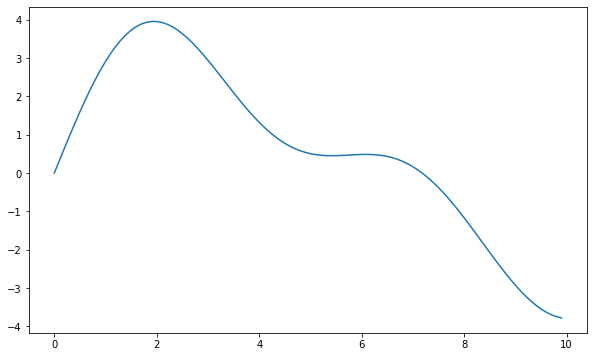

In [20]:
T = 100
t = torch.arange(T)/T * 10
y_true = 3*torch.sin(0.5*t) + 1.2*torch.sin(1.0*t) + 0.5*torch.sin(1.2*t) 
y = y_true + torch.randn(T)
plt.figure(figsize=(10,6))
plt.plot(t,y_true)

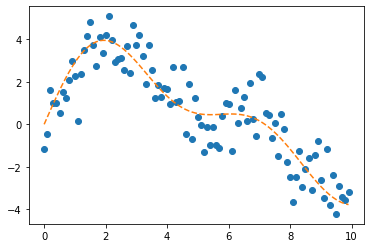

In [21]:
plt.plot(t,y,'o')
plt.plot(t,y_true,'--')

In [22]:
f = torch.tensor(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

  f = torch.tensor(y)
<ipython-input-19-cc3dd6c135ce>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(W.sum(dim=1))

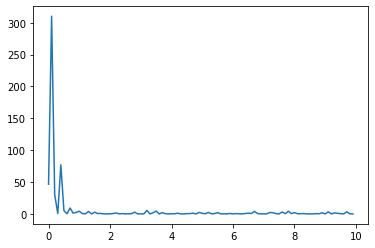

In [23]:
plt.plot(t,fbar**2) # periodogram 

In [24]:
fbar_threshed = ebayesthresh_torch.ebayesthresh(fbar[:,0])

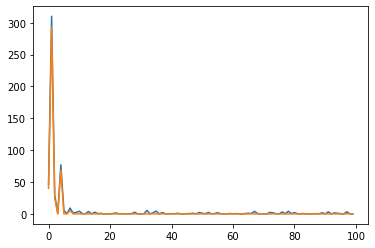

In [25]:
# fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 


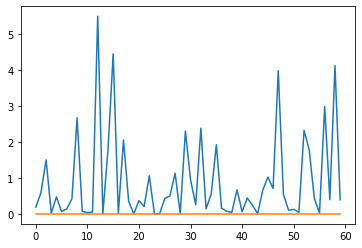

In [26]:
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

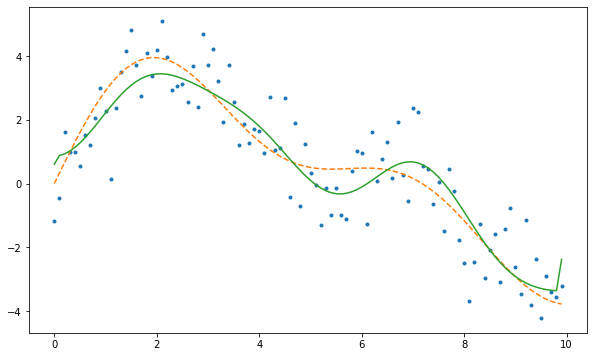

In [36]:
yhat = Psi @ fbar_threshed.float() # inverse dft
plt.figure(figsize=(10,6))
plt.plot(t,y,'.')
plt.plot(t,y_true,'--')
plt.plot(t,yhat)

In [38]:
class ebayesthresh_nn(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,input):
        return ebayesthresh_torch.ebayesthresh(input)

In [39]:
thresh_layer = ebayesthresh_nn()

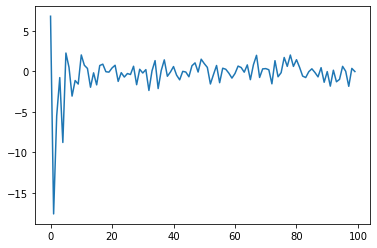

In [40]:
plt.plot(fbar[:,0])

/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.isnan(torch.tensor(sdev)):
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:584: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(s, dtype=torch.float)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(tt, dtype=torch.float64)
/home/csy/Dropbox/sy_hub/posts/1_Note/ebayesthresh_torch/utils.py:556: UserW

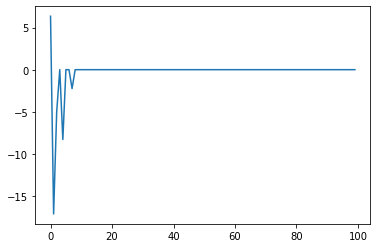

In [41]:
plt.plot(thresh_layer(fbar[:,0]))